In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv("data.csv")
df = df[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={"msrp": "price"})

In [4]:
mean = df['price'].mean()
df['above_average'] = (df['price'] > mean).astype(int)

In [6]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# Question 1

In [11]:
from sklearn.metrics import roc_auc_score

for feat in ['engine_hp','engine_cylinders','highway_mpg','city_mpg']:
    if roc_auc_score(df['above_average'], df[feat]) > 0.5:
        print(feat + ': ' + str(roc_auc_score(df['above_average'], df[feat])))
    else:
        print(feat + ': ' + str(roc_auc_score(df['above_average'], -df[feat])))
    

engine_hp: 0.9157738865600598
engine_cylinders: 0.765740332665676
highway_mpg: 0.6307493974364577
city_mpg: 0.6706787971410986


# Question 2

In [12]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values

del df_train['above_average']
del df_val['above_average']

del df_train['price']
del df_val['price']

In [14]:
from sklearn.feature_extraction import DictVectorizer
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_train.shape

(7148, 954)

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [16]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [23]:
y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred),4)

0.9796

# Question 3

In [28]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))
    
columns = ['threshold','precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

C:\Users\Wim\AppData\Local\Temp\ipykernel_17396\4050584650.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


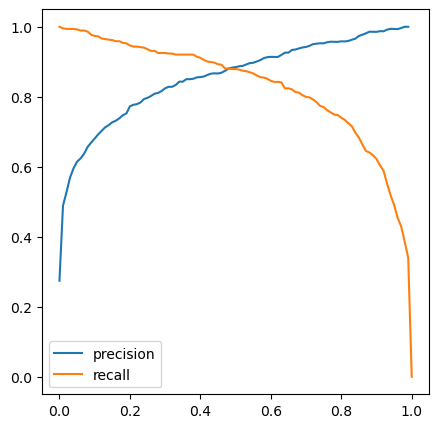

In [32]:
plt.figure(figsize=(5, 5))


plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

# Question 4

In [33]:
df_scores['F1'] = 2*df_scores.precision*df_scores.recall / (df_scores.precision + df_scores.recall)

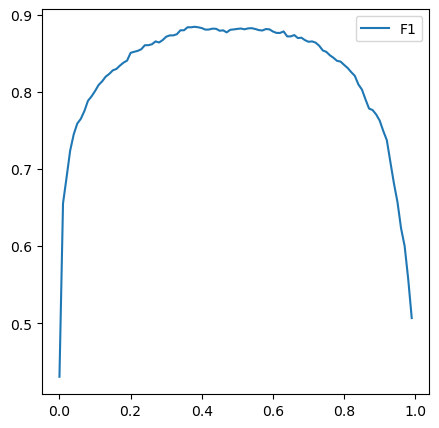

In [34]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

# Question 5

In [37]:
from sklearn.model_selection import KFold
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    del df_train['price']
    del df_val['price']


    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [40]:
np.std(scores)

0.002553543790218258

# Question 6

In [42]:
for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']

        del df_train['price']
        del df_val['price']


        train_dict = df_train.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        X_train = dv.transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f'for C = {C} the mean AUC is: {round(np.mean(scores),3)} and the std is: {round(np.std(scores),3)}')

for C = 0.01 the mean AUC is: 0.952 and the std is: 0.002
for C = 0.1 the mean AUC is: 0.972 and the std is: 0.002
for C = 0.5 the mean AUC is: 0.979 and the std is: 0.004
for C = 10 the mean AUC is: 0.984 and the std is: 0.003
